In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
ds_root_dir = "/kaggle/input/penn-fudan-pedestrian-dataset-for-segmentation/PennFudanPed"

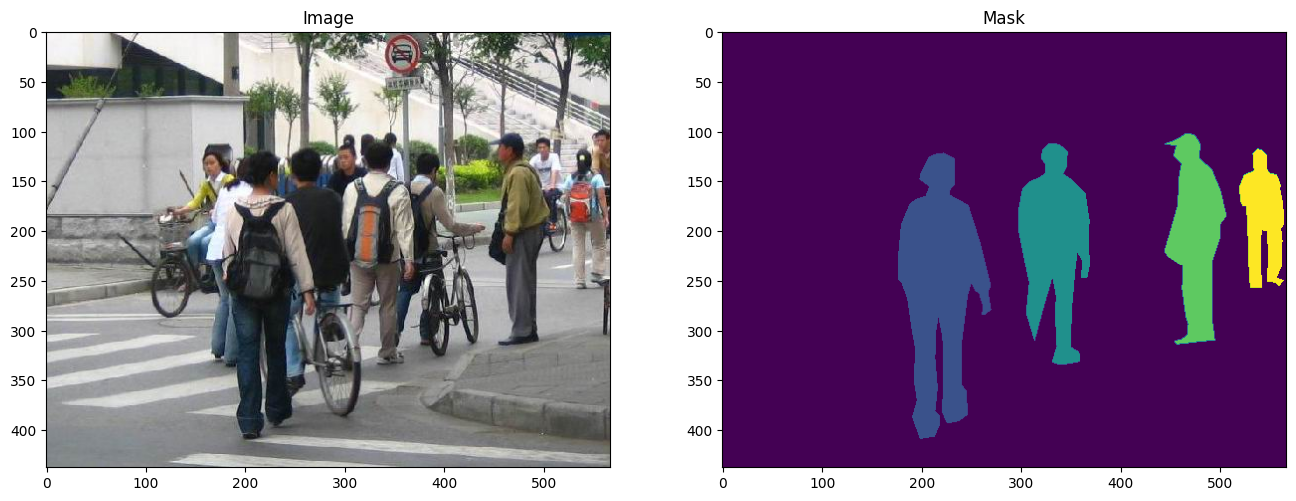

In [5]:
import matplotlib.pyplot as plt
from torchvision.io import read_image
import os


image = read_image(os.path.join(ds_root_dir, "train_images/FudanPed00046.png"))
mask = read_image(os.path.join(ds_root_dir, "train_masks/FudanPed00046_mask.png"))

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

In [13]:
import torch

from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F


class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, ds_type, transforms):
        self.root_dir = root_dir
        self.ds_type = ds_type
        self.transforms = transforms
        self.imgs = list(sorted(os.listdir(os.path.join(root_dir, ds_type + "_images"))))
        self.masks = list(sorted(os.listdir(os.path.join(root_dir, ds_type + "_masks"))))

    def __getitem__(self, idx):
        img_path = os.path.join(os.path.join(self.root_dir, self.ds_type + "_images", self.imgs[idx]))
        mask_path = os.path.join(os.path.join(self.root_dir, self.ds_type + "_masks", self.masks[idx]))
        img = read_image(img_path)
        mask = read_image(mask_path)
        
        obj_ids = torch.unique(mask)
        obj_ids = obj_ids[1:]
        num_objs = len(obj_ids)

        masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)
        
        # get bounding box coordinates for each mask
        boxes = masks_to_boxes(masks)
        
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        
        image_id = idx
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        # suppose all instances are not crowd
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # Wrap sample and targets into torchvision tv_tensors:
        img = tv_tensors.Image(img)

        target = {}
        target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
        target["masks"] = tv_tensors.Mask(masks)
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            img, target = self.transforms(img, target)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [14]:
from torchvision.transforms import v2 as T


def get_transform(train):
    transforms = []
    if train:
        transforms.append(T.RandomHorizontalFlip(0.5))
    transforms.append(T.ToDtype(torch.float, scale=True))
    transforms.append(T.ToPureTensor())
    return T.Compose(transforms)

In [21]:
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py")
os.system("wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py")

--2025-10-04 10:28:06--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4063 (4.0K) [text/plain]
Saving to: ‘engine.py.1’

     0K ...                                                   100% 55.4M=0s

2025-10-04 10:28:06 (55.4 MB/s) - ‘engine.py.1’ saved [4063/4063]

--2025-10-04 10:28:06--  https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8388 (8.2K) [text/plain]
S

0

In [16]:
import utils

train_dataset = PennFudanDataset(ds_root_dir, "train", get_transform(train=True))
data_loader = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=utils.collate_fn)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
print(images)
print(targets)

[tensor([[[0.6039, 0.6118, 0.6275,  ..., 1.0000, 1.0000, 1.0000],
         [0.6510, 0.6353, 0.6353,  ..., 1.0000, 1.0000, 1.0000],
         [0.6863, 0.6667, 0.6627,  ..., 1.0000, 1.0000, 1.0000],
         ...,
         [0.7529, 0.8118, 0.8471,  ..., 0.2745, 0.2510, 0.2706],
         [0.8784, 0.9608, 1.0000,  ..., 0.2863, 0.2431, 0.2588],
         [0.8353, 0.9333, 1.0000,  ..., 0.2000, 0.1490, 0.1961]],

        [[0.4549, 0.4627, 0.4588,  ..., 1.0000, 0.9961, 0.9961],
         [0.5020, 0.4863, 0.4667,  ..., 1.0000, 0.9961, 0.9961],
         [0.5333, 0.5137, 0.4941,  ..., 1.0000, 0.9961, 0.9961],
         ...,
         [0.7529, 0.8118, 0.8471,  ..., 0.2627, 0.2392, 0.2588],
         [0.8784, 0.9608, 1.0000,  ..., 0.2824, 0.2392, 0.2549],
         [0.8353, 0.9333, 1.0000,  ..., 0.1961, 0.1529, 0.2000]],

        [[0.3804, 0.3882, 0.3922,  ..., 1.0000, 1.0000, 1.0000],
         [0.4275, 0.4118, 0.4000,  ..., 1.0000, 1.0000, 1.0000],
         [0.4667, 0.4471, 0.4314,  ..., 1.0000, 1.0000, 1

# Model Creation

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    print(in_features)
    
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    print(in_features_mask)
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

    return model

In [18]:
device = torch.accelerator.current_accelerator() if torch.accelerator.is_available() else torch.device('cpu')
print(device)

cuda


In [22]:
from engine import train_one_epoch, evaluate

# our dataset has two classes only - background and person
num_classes = 2

dataset = PennFudanDataset(ds_root_dir, "train", get_transform(train=True))
dataset_test = PennFudanDataset(ds_root_dir, "valid", get_transform(train=False))


# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn)

model = get_model_instance_segmentation(num_classes)
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

print("That's it!")

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:00<00:00, 211MB/s] 


1024
256


/kaggle/working/engine.py:30: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/73]  eta: 0:03:26  lr: 0.000074  loss: 4.8932 (4.8932)  loss_classifier: 0.5475 (0.5475)  loss_box_reg: 0.1018 (0.1018)  loss_mask: 4.2155 (4.2155)  loss_objectness: 0.0252 (0.0252)  loss_rpn_box_reg: 0.0032 (0.0032)  time: 2.8293  data: 0.0516  max mem: 2187
Epoch: [0]  [10/73]  eta: 0:00:37  lr: 0.000768  loss: 1.6910 (2.4296)  loss_classifier: 0.4182 (0.3989)  loss_box_reg: 0.2115 (0.2455)  loss_mask: 1.0845 (1.7609)  loss_objectness: 0.0178 (0.0198)  loss_rpn_box_reg: 0.0037 (0.0044)  time: 0.5929  data: 0.0517  max mem: 2763
Epoch: [0]  [20/73]  eta: 0:00:26  lr: 0.001462  loss: 0.8981 (1.5732)  loss_classifier: 0.2108 (0.2852)  loss_box_reg: 0.2085 (0.2354)  loss_mask: 0.3113 (1.0297)  loss_objectness: 0.0126 (0.0180)  loss_rpn_box_reg: 0.0037 (0.0049)  time: 0.3793  data: 0.0624  max mem: 2767
Epoch: [0]  [30/73]  eta: 0:00:19  lr: 0.002156  loss: 0.5863 (1.2628)  loss_classifier: 0.1338 (0.2337)  loss_box_reg: 0.2073 (0.2416)  loss_mask: 0.1965 (0.7651)  loss_ob

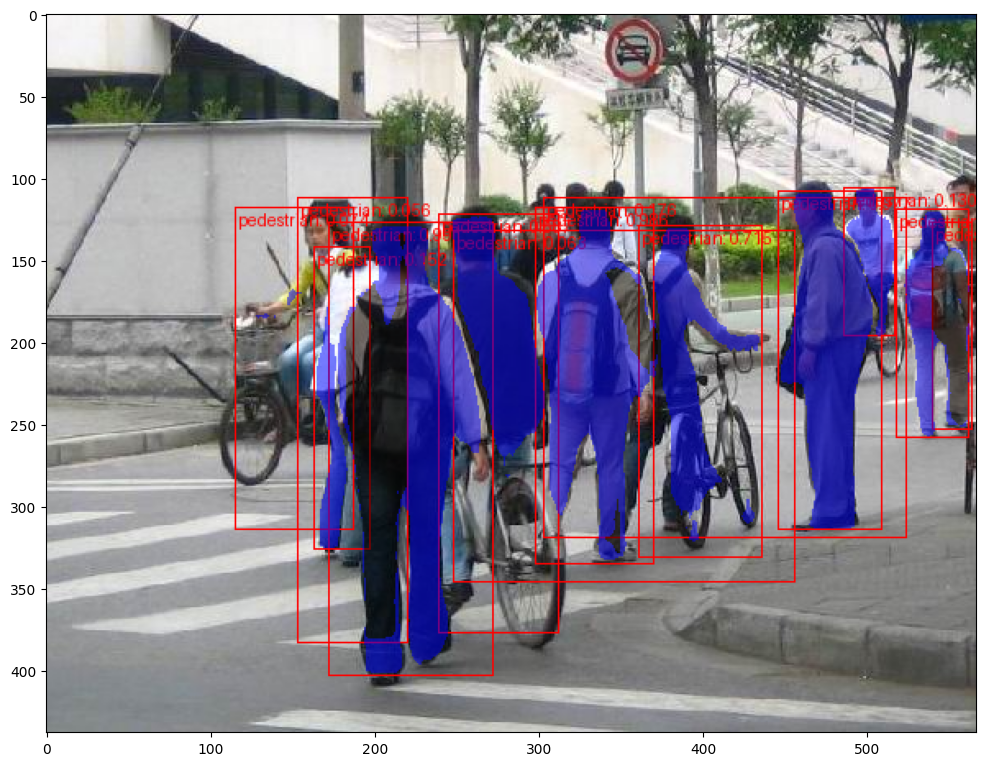

In [24]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(os.path.join(ds_root_dir, "train_images/FudanPed00046.png"))
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
    x = eval_transform(image)
    # convert RGBA -> RGB and move to device
    x = x[:3, ...].to(device)
    predictions = model([x, ])
    pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))